# **Stochastic Simulation Assignment 2**

---


### **Contributors**  
- **Maarten Stork**  
- **Paul Jungnickel**  
- **Lucas Keijzer**

### **Overview**  
This notebook contains the code and analysis for **Assignment 2 of Stochastic Simulation**. The code follows the order specified in the assignment guidelines and replicates the experiments conducted in the referenced paper. Each section corresponds to a key experiment(s).

In [ ]:
# Imports
import simpy
import queue
import numpy.random as rand
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from stochasticQueueing import *

## 2nd Question) Experimentations with Server Numbers

THIS SHOULD BE THE SUBRESEARCH QUESTION, NOT IN THE PAPER YET:

Research Question "How does the number of servers (n) in an M/M/n queueing system affect the mean waiting time as the system load ( ρ) approaches saturation?" 

Hypotheses Null Hypothesis ( H 0 ​ ): "There is no significant difference in the mean waiting times between different numbers of servers (n) in an M/M/n queueing system as the system load changes." 
Alternative Hypothesis ( H 1 ​ ): "The mean waiting time differs significantly between different numbers of servers (n) in an M/M/n queueing system, with an increasing number of servers leading to shorter mean waiting times under identical system loads."

The following code block provides Python functions to simulate various queueing systems and compute key performance metrics. It includes implementations for queue simulations, Erlang B formula calculations, waiting probabilities, and expected waiting times.

In [ ]:
def M_M_n_simulation(system_load, server_count, sim_duration, seed=42, queue_type='FIFO'):
    """
    Simulates an M/M/n queueing system.

    Parameters:
    - system_load: The load factor of the system (λ/μ).
    - server_count: The number of servers in the system.
    - sim_duration: The duration of the simulation.
    - seed: Seed for the random number generator to ensure reproducibility (default is 42).
    - queue_type: Type of queue (default is 'FIFO').

    Returns:
    - sim.results(): Results of the queueing simulation.
    """

    # Set arrival and service rates
    arrival_rate = server_count
    service_rate = 1 / system_load

    arrival_dist = lambda: rand.exponential(1 / arrival_rate)
    service_dist = lambda: rand.exponential(1 / service_rate)

    # Initialize and run the simulation
    sim = ServerQueueingSimulation(
        arrival_dist, service_dist, server_count, queue_type=queue_type, sim_duration=sim_duration, seed=seed
    )
    return sim.results()

def B(c, rho):
    """
    Recursively calculates the Erlang B formula.

    Parameters:
    - c: The number of servers.
    - rho: The traffic intensity (λ / μ).

    Returns:
    - The probability of all servers being busy (blocking probability).
    """
    if c == 0:
        return 1
    Bprev = B(c-1, rho)

    return (rho * Bprev) / (c + rho * Bprev)

def PiW(c, rho):
    """
    Calculates the probability of waiting in the queue.

    Parameters:
    - c: The number of servers.
    - rho: The traffic intensity per server (λ / μ / c).

    Returns:
    - The probability that a customer has to wait.
    """
    Bprev = B(c-1, c * rho)
    return (rho * Bprev) / (1 - rho + rho * Bprev)

def expectedWaitingTime(c, rho):
    """
    Calculates the expected waiting time in the queue.

    Parameters:
    - c: The number of servers.
    - rho: The traffic intensity (λ / μ).

    Returns:
    - The expected waiting time for a customer.
    """
    if c == 1:
        return rho ** 2 / (1 - rho)
    else:
        Pi = PiW(c, rho)
        return Pi / ((1 - rho) * (c / rho))


## plots for $\rho$

In [ ]:

server_counts = [1, 2, 4]
num_runs = 20
rand.seed(42)
# system_loads = 1 - np.logspace(-0.5, -4, 9)
system_loads = np.linspace(0.4,0.99, 10)
durations = 100000*np.ones_like(system_loads)
durations[7:] *=5
wait_time_measurements = np.zeros([len(durations), len(system_loads), num_runs])
mean_wait_time = np.zeros([len(durations), len(system_loads)])
std_wait_time = np.zeros([len(durations), len(system_loads)])
for N, server_count in enumerate(server_counts):
    for i, system_load in enumerate(system_loads):
        for j in range(num_runs):
            
            res = M_M_n_simulation(system_load, server_count, sim_duration=durations[i], warmup_duration=0.9*durations[i], seed=rand.randint(0,2**31-1))
            wait_time_measurements[N, i, j] = res['Average Wait Time']

        mean_wait_time[N, i] = np.mean(wait_time_measurements[N,i,:])
        std_wait_time[N, i] = np.std(wait_time_measurements[N,i,:])
    # plt.plot(1 - system_loads, mean_wait_time, label=f'{server_count}')
    print(server_count, 'done')




np.savez('data/servcount.npz', mean_wait_time, std_wait_time, wait_time_measurements)

arrays = np.load('data/servcount.npz')
mean_wait_time, std_wait_time, wait_time_measurements= arrays['arr_0'], arrays['arr_1'], arrays['arr_2']


for N, server_count in enumerate(server_counts):
    
    plt.errorbar(system_loads, mean_wait_time[N], 1.96*std_wait_time[N]/np.sqrt(num_runs), linestyle='', label=f'{server_count}', capsize=5, elinewidth=1)


plot_loads = np.linspace(system_loads[0], system_loads[-1], 1000)
for c in server_counts:
    plt.plot(plot_loads, expectedWaitingTime(c, plot_loads), linestyle=':', color='grey')
# plt.plot(0.5, 0, linestyle=':', color='grey', label='expected waiting time')
plt.grid()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel('mean wait time', fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.legend(title='server count', fontsize=12)
# plt.savefig('plots/2).png', dpi=600)


MAARTEN ADDED THE FOLLOWING TWO, CLEAN UP TOMORROW:

In [ ]:
server_counts = [1, 2, 4, 8, 16]
num_runs = 100
rand.seed(42)
system_loads = 1 - np.logspace(-0.5, -7, 15)

waiting_times = {n: [] for n in server_counts}

for server_count in server_counts:
    for i, system_load in enumerate(system_loads):
        wait_times = []
        for j in range(num_runs):
            res = M_M_n_simulation(system_load, server_count, 1000, seed=rand.randint(0, 2**31 - 1))
            wait_times.append(res['Average Wait Time'])
        waiting_times[server_count].extend(wait_times)

print("Mann-Whitney U-tests Results:")
for i, n1 in enumerate(server_counts):
    for j, n2 in enumerate(server_counts):
        if j > i:  # Compare each pair of server counts
            u_stat, p_val = mannwhitneyu(waiting_times[n1], waiting_times[n2], alternative='two-sided')
            print(f"Server Count {n1} vs {n2}: U-statistic = {u_stat:.4f}, p-value = {p_val:.4e}")

In [ ]:
# Perform the Kruskal-Wallis test
filtered_waiting_times = [waiting_times[n] for n in [1, 2, 4]]
kruskal_results = kruskal(*filtered_waiting_times)

# Print the results
print(f"Kruskal-Wallis H-statistic: {kruskal_results.statistic:.4f}, p-value: {kruskal_results.pvalue:.4e}")

# Perform pairwise U-tests
pairs = [(1, 2), (1, 4), (2, 4)]
for n1, n2 in pairs:
    u_stat, p_val = mannwhitneyu(waiting_times[n1], waiting_times[n2], alternative='two-sided')
    print(f"Server Count {n1} vs {n2}: U-statistic = {u_stat:.4f}, p-value = {p_val:.4e}")


Kruskal-Wallis H-statistic: 638.7165, p-value: 2.0159e-139
Server Count 1 vs 2: U-statistic = 1470029.0000, p-value = 6.2597e-48
Server Count 1 vs 4: U-statistic = 1706198.0000, p-value = 1.4288e-132
Server Count 2 vs 4: U-statistic = 1413281.0000, p-value = 5.5334e-34


## Plots for Duration

In [ ]:
# Run to get data

# parameters used
server_count = 1
run_count = [1000, 1000,200, 200,50, 50,20, 20, 10,5]
rand.seed(42)
system_loads = [0.2, 0.5, 0.8, 0.9, 0.99, 0.999]
max_duration = np.logspace(3, 7, 10)
mean_wait_time = np.zeros([len(system_loads), len(max_duration)])
std_wait_time = np.zeros([len(system_loads), len(max_duration)])

# Run simulations for different system loads
for l, system_load in enumerate(system_loads):
    for i, duration in enumerate(max_duration):

        num_runs = run_count[i]
        
        wait_times = np.zeros(num_runs)
        for j in range(num_runs):
            
            res = M_M_n_simulation(system_load, server_count, duration, seed=rand.randint(0,2**31-1), warmup_duration=0.9*duration)
            wait_times[j] = res['Average Wait Time']

        mean_wait_time[l,i] = np.mean(wait_times)
        std_wait_time[l,i] = np.std(wait_times)
        print('.')
    # plt.plot(1 - system_loads, mean_wait_time, label=f'{server_count}')
    print(system_load, np.mean(std_wait_time[-1]))

np.savez('data/duration-convergence-2.npz', mean_wait_time, std_wait_time)


In [ ]:
# load data
arrays = np.load('data/duration-convergence-2.npz')
mean_wait_time, std_wait_time = arrays['arr_0'], arrays['arr_1']

# create plot
plt.figure(constrained_layout=True)

for l, system_load in enumerate(system_loads):

    plt.errorbar(max_duration, mean_wait_time[l], 1.96*std_wait_time[l]/np.sqrt(run_count[l]), linestyle='',  label=f'{system_load}', capsize=5, elinewidth=1)

# Configure plot
plt.tight_layout()
plt.grid()
plt.ylim(0.011,10000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'simulation duration', fontsize=14)
plt.ylabel('mean wait time', fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.legend(title='system load', loc=2, ncols=3, fontsize=12)
plt.savefig('plots/duration-0.9-warmup.png', dpi=600 )

## 3) FIFO & SFJ


THIS SHOULD BE THE SUBRESEARCH QUESTION, NOT IN THE PAPER YET:

"How does the choice of queue discipline (FIFO vs SJF) impact mean waiting times in an M/M/1 queuing system under varying system loads?" 

Hypotheses Null Hypothesis ( H 0 ​ ): "There is no significant difference in the mean waiting times between FIFO and SJF queue disciplines across varying system loads." 
Alternative Hypothesis ( H 1 ​ ): "The mean waiting time differs significantly between FIFO and SJF queue disciplines, with SJF leading to shorter waiting times under identical system loads."

MAARTEN ADDED THE FOLLOWING, CLEAN UP TOMORROW:

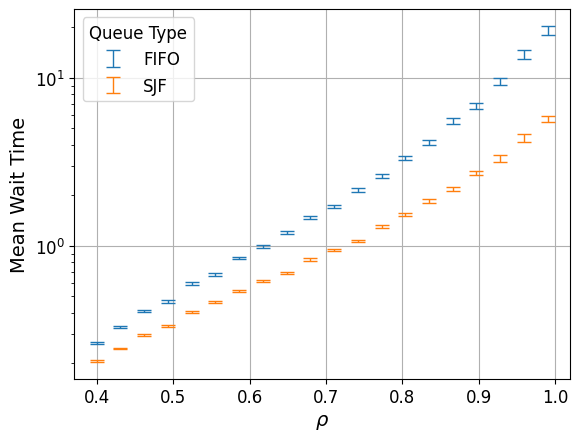

Mann-Whitney U-test: U-statistic = 2565980.0000, p-value = 3.5758e-54


In [ ]:
# Define parameters
server_counts = [1]
num_runs = 100
rand.seed(42)
system_loads = np.linspace(0.4, 0.99, 20)


# Store waiting times for each queue type
waiting_times = {queue_type: [] for queue_type in ['FIFO', 'SJF']}

# Run simulations for each queue type
for queue_type in ['FIFO', 'SJF']:
    mean_wait_time = np.zeros_like(system_loads)
    std_wait_time = np.zeros_like(system_loads)
    for i, system_load in enumerate(system_loads):
        wait_times = []
        for j in range(num_runs):
            res = M_M_n_simulation(
                system_load, server_counts[0], 1000, seed=rand.randint(0, 2**31 - 1), queue_type=queue_type
            )
            wait_times.append(res['Average Wait Time'])

        # Store waiting times for later statistical testing
        waiting_times[queue_type].extend(wait_times)

        # Calculate mean and std deviation
        mean_wait_time[i] = np.mean(wait_times)
        std_wait_time[i] = np.std(wait_times)

    # Plot mean waiting times with error bars
    plt.errorbar(
        system_loads,  # Plotting against rho
        mean_wait_time,
        std_wait_time / np.sqrt(num_runs),  # 95% confidence intervals
        linestyle='',
        label=f'{queue_type}',
        capsize=5,
        elinewidth=1,
    )

# Configure plot
plt.grid()
plt.yscale('log')
plt.xlabel(r'$\rho$', fontsize=14) 
plt.ylabel('Mean Wait Time', fontsize=14) 
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.legend(title='Queue Type', title_fontsize=12, fontsize=12)
plt.show()

# Perform Mann-Whitney U-test
u_stat, p_val = mannwhitneyu(waiting_times['FIFO'], waiting_times['SJF'], alternative='two-sided')
print(f"Mann-Whitney U-test: U-statistic = {u_stat:.4f}, p-value = {p_val:.4e}")


## 4th Question) Different Service Rate Distributions

This code block defines two functions for simulating queueing systems with various service time distributions. The first function, `M_X_n_simulation`, simulates an M/X/n queueing system, allowing for customizable service distributions. The second function, `run_simulations_varying_rho_service_distributions`, performs multiple simulations to compare how different service distributions affect waiting times across varying system loads, providing graphical and statistical analysis of the results.

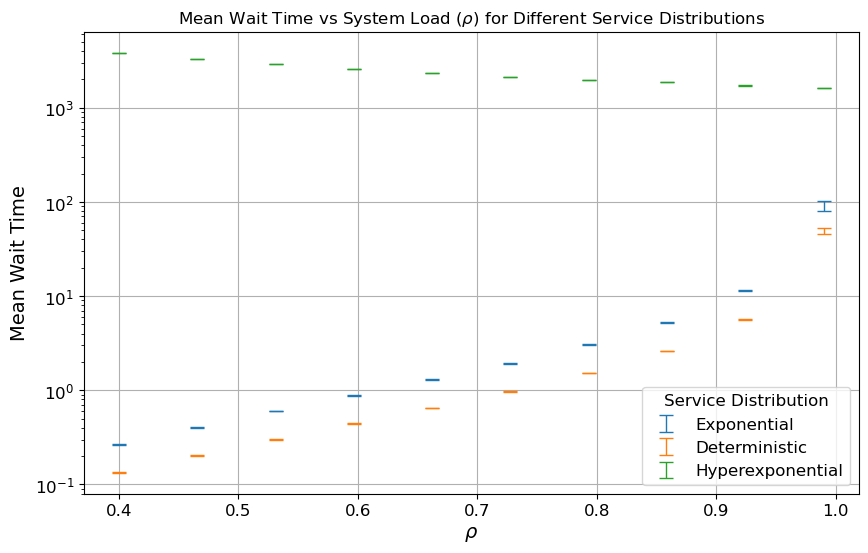


All Data Points for Waiting Times:
Exponential Waiting Times: [0.27186793215483684, 0.26944981157832054, 0.26415167780307525, 0.2608324408692895, 0.2624589716165166, 0.27423891280800744, 0.26269351368369326, 0.2589792002765875, 0.2757580909652352, 0.26678854952463726, 0.26630207167329106, 0.2673479050262555, 0.26612995260262684, 0.2632400046377693, 0.2755746025170224, 0.27005118869566835, 0.2644784570837226, 0.27373890542310136, 0.25841341470347384, 0.26852621977336455, 0.40512495090676887, 0.4062846386476352, 0.41333797379949355, 0.4132450101669004, 0.40824485819499196, 0.4004840920008523, 0.39479707349682797, 0.42142350964210984, 0.4003357609499833, 0.408396989346876, 0.3912516087935369, 0.3979861544156771, 0.412076287538569, 0.4002664465962015, 0.41630793978022795, 0.3999472706853177, 0.40066809395070146, 0.4054367447659505, 0.3901880084181276, 0.3960468603394846, 0.5880059326719271, 0.6095327540463982, 0.6039893272941849, 0.6153481189333915, 0.595068482406455, 0.6128946948224818, 

NameError: name 'stats' is not defined

In [23]:
def M_X_n_simulation(system_load, server_count, sim_duration, seed=None, service_dist=None):
    """
    Simulates an M/X/n queueing system.

    Parameters:
    - system_load: The load factor of the system (λ/μ).
    - server_count: The number of servers in the system.
    - sim_duration: The duration of the simulation.
    - seed: Seed for the random number generator to ensure reproducibility (default is None).
    - service_dist: Custom service distribution (default is exponential).

    Returns:
    - sim.results(): Results of the queueing simulation.
    """

    if seed is not None:
        rand.seed(seed)

    # Set arrival rate and job completion rate
    arrival_rate = server_count
    job_completion_rate = 1 / system_load
    
    arrival_dist = lambda: rand.exponential(1 / arrival_rate)

    # Use default exponential service distribution if none is provided
    if service_dist is None:
        service_dist = lambda: rand.exponential(1 / job_completion_rate)

    # Initialize and run the simulation
    sim = ServerQueueingSimulation(arrival_dist, service_dist, server_count, sim_duration=sim_duration, seed=seed)
    
    return sim.results()

def run_simulations_varying_rho_service_distributions():
    """
    Runs simulations for different service distributions with varying system load (rho).

    Returns:
    - A plot showing mean waiting times with confidence intervals for each service distribution.
    - Prints summary statistics for waiting times.
    """
    service_distributions = ['exponential', 'deterministic', 'hyperexponential']
    num_runs = 20
    system_loads = np.linspace(0.4, 0.99, 10)
    durations = 100000 * np.ones_like(system_loads)
    durations[7:] *= 5
    
    rand.seed(42)
    plt.figure(figsize=(10, 6))
    
    waiting_times = {service_type: [] for service_type in service_distributions}
    
    for service_type in service_distributions:
        mean_wait_time = np.zeros_like(system_loads)
        std_wait_time = np.zeros_like(system_loads)
        
        # Loop over different system loads (rho values)
        for i, system_load in enumerate(system_loads):
            sim_duration = durations[i]
            wait_times = np.zeros(num_runs)
            
            # Run multiple simulations to collect data for statistical analysis
            for j in range(num_runs):
                seed = rand.randint(0, 2**31 - 1)
                
                # Define service distribution based on type
                if service_type == 'exponential':
                    service_dist = lambda: rand.exponential(1 / (1 / system_load))
                elif service_type == 'deterministic':
                    service_dist = lambda: 1 / (1 / system_load)
                elif service_type == 'hyperexponential':
                    def service_dist():
                        if rand.rand() < 0.75:
                            return rand.exponential(2/system_load)
                        else:
                            return rand.exponential(2/(5*system_load))
                else:
                    raise ValueError("Unsupported service time distribution")
                
                # Run the simulation and record the average waiting time
                res = M_X_n_simulation(system_load, 1, sim_duration, seed=seed, service_dist=service_dist)
                wait_times[j] = res['Average Wait Time']
            
            # Store waiting times for statistical analysis
            waiting_times[service_type].extend(wait_times)
            
            # Calculate mean and standard deviation of waiting times for the current system load
            mean_wait_time[i] = np.mean(wait_times)
            std_wait_time[i] = np.std(wait_times)
        
        # Plotting mean waiting time with confidence intervals for the current service distribution
        plt.errorbar(system_loads, mean_wait_time, 
                    yerr=1.96 * std_wait_time / np.sqrt(num_runs), 
                    linestyle='', label=f'{service_type.capitalize()}', capsize=5, elinewidth=1)

    # Configure plot appearance
    plt.grid()
    # plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\rho$', fontsize=14)  # Update to use rho
    plt.ylabel('Mean Wait Time', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Service Distribution', title_fontsize=12, fontsize=12)
    plt.title(r'Mean Wait Time vs System Load ($\rho$) for Different Service Distributions')
    plt.savefig('plots/4).png', dpi=600)
    plt.show()


    # Output all data points for each distribution
    print("\nAll Data Points for Waiting Times:")
    for service_type in waiting_times:
        print(f"{service_type.capitalize()} Waiting Times: {waiting_times[service_type]}")

    # Print summary statistics for each distribution
    means = {}
    std_devs = {}
    for service_type in waiting_times:
        mean_wait = np.mean(waiting_times[service_type])
        std_wait = np.std(waiting_times[service_type])
        means[service_type] = mean_wait
        std_devs[service_type] = std_wait
        print(f"{service_type.capitalize()} - Mean Waiting Time: {mean_wait:.4f}, Std Dev: {std_wait:.4f}")

    # Kruskal-Wallis test to check if there are significant differences between the average waiting times
    h_stat, p_value = stats.kruskal(waiting_times['exponential'], waiting_times['deterministic'], waiting_times['hyperexponential'])
    print(f"\nKruskal-Wallis H-statistic: {h_stat:.4f}, p-value: {p_value:.4g}")

    # Mann-Whitney U-tests to further analyze differences between distributions
    u_exp_det, p_exp_det = stats.mannwhitneyu(waiting_times['exponential'], waiting_times['deterministic'], alternative='two-sided')
    u_exp_hyper, p_exp_hyper = stats.mannwhitneyu(waiting_times['exponential'], waiting_times['hyperexponential'], alternative='two-sided')
    u_det_hyper, p_det_hyper = stats.mannwhitneyu(waiting_times['deterministic'], waiting_times['hyperexponential'], alternative='two-sided')

    print("\nMann-Whitney U-tests Results:")
    print(f"Exponential vs Deterministic: U-statistic = {u_exp_det:.4f}, p-value = {p_exp_det:.4g}")
    print(f"Exponential vs Hyperexponential: U-statistic = {u_exp_hyper:.4f}, p-value = {p_exp_hyper:.4g}")
    print(f"Deterministic vs Hyperexponential: U-statistic = {u_det_hyper:.4f}, p-value = {p_det_hyper:.4g}")

# Example Usage
run_simulations_varying_rho_service_distributions()


In [29]:
import numpy as np
import pandas as pd
from scipy import stats

# Sample data initialization
waiting_times = {
    'exponential': [0.27186793215483684, 0.26944981157832054, 0.26415167780307525, 0.2608324408692895, 0.2624589716165166, 0.27423891280800744, 0.26269351368369326, 0.2589792002765875, 0.2757580909652352, 0.26678854952463726, 0.26630207167329106, 0.2673479050262555, 0.26612995260262684, 0.2632400046377693, 0.2755746025170224, 0.27005118869566835, 0.2644784570837226, 0.27373890542310136, 0.25841341470347384, 0.26852621977336455, 0.40512495090676887, 0.4062846386476352, 0.41333797379949355, 0.4132450101669004, 0.40824485819499196, 0.4004840920008523, 0.39479707349682797, 0.42142350964210984, 0.4003357609499833, 0.408396989346876, 0.3912516087935369, 0.3979861544156771, 0.412076287538569, 0.4002664465962015, 0.41630793978022795, 0.3999472706853177, 0.40066809395070146, 0.4054367447659505, 0.3901880084181276, 0.3960468603394846, 0.5880059326719271, 0.6095327540463982, 0.6039893272941849, 0.6153481189333915, 0.595068482406455, 0.6128946948224818, 0.607289496734592, 0.6031526534023457, 0.5863229177654795, 0.5988440465312918, 0.5921893534213828, 0.591974728369792, 0.6137089912543784, 0.6033556325248745, 0.6014529216320345, 0.6005079582344481, 0.629141737628746, 0.6116981101375607, 0.6018865851809505, 0.6028484571064948, 0.8935133116964314, 0.8792843802812519, 0.8913456198535578, 0.9082178952869095, 0.8886913434736293, 0.8754167255551142, 0.8932080399369595, 0.8819329343540325, 0.8884479059395859, 0.8466637668492675, 0.9103762643613279, 0.8742950220150686, 0.8939256551765423, 0.8884038475978416, 0.8910569769951363, 0.8914831798869554, 0.9073806996914944, 0.8833040198448974, 0.8538686800358173, 0.8596514462867223, 1.2613725487140044, 1.3111662377232827, 1.2581032069194884, 1.3070967944691723, 1.3366776632317368, 1.3001919358876193, 1.3040937087069144, 1.3116855177902513, 1.2928148873900471, 1.3703253164242086, 1.2849332867098366, 1.3118707177619278, 1.2402013476115172, 1.344390827464196, 1.331522215075169, 1.320935918167861, 1.2947036031822197, 1.2941241442643256, 1.360922939570166, 1.3185977487505391, 1.9613343703964885, 2.0289046918364235, 1.9239507396466557, 1.9972844041642857, 1.849843002259885, 1.9436243713969321, 1.8871811975294983, 1.987457247871106, 1.943759104594356, 1.9109876884292571, 1.9014686846562827, 1.9744471897481906, 1.9066932775782637, 1.9302812862704188, 1.9294364361866032, 2.0121576565031174, 1.958710310649298, 1.8531101847436238, 1.9398479404565, 1.9789631709777682, 3.019978955295912, 3.2460118786998318, 2.948504236384346, 3.0048467982377236, 3.2408074193835628, 3.188378341618703, 3.231100783113234, 3.023830460287559, 3.054335987482857, 3.251100174836903, 3.0352933990462154, 2.9589450678023583, 3.0392035380415816, 3.1013037369654164, 3.02376789957506, 3.1398331978809657, 3.000814885498351, 2.9048210695539387, 2.9367615015158326, 3.0247437537318786, 5.151971003915114, 5.25011823193659, 5.3369516339472876, 5.340599509269533, 5.240987200246959, 5.248834079276488, 5.38438017536248, 5.1634192968027515, 5.125773675763847, 5.443831844244865, 5.159457221450175, 5.160365511504082, 5.624194459702508, 5.15613617306494, 4.998794239819881, 5.288489867378551, 5.348632339304441, 5.304456700660015, 5.23091142066097, 5.162502802466988, 10.955287026362166, 11.10728878495786, 10.873072023530355, 10.861932361239443, 12.231521244039616, 11.82957394728959, 12.369130522523603, 11.014515229693615, 10.88332518369941, 11.775106245277554, 11.45829113052159, 11.862457826144958, 11.689708672019151, 11.416249905118994, 11.129698532686682, 10.86084172445922, 12.6529755474856, 11.506982839588378, 11.024241704153972, 11.227737895510296, 88.88535215957145, 76.75616277812048, 62.01428183931804, 90.97944907548683, 59.0739712877193, 81.06231764821962, 79.20581240802461, 167.12964940999134, 85.28291872958108, 76.11590930064636, 78.18713199638958, 118.6150697883006, 74.8493617274811, 100.48772387757265, 96.74459803910841, 75.401541292566, 75.42012090999306, 99.49189578434127, 110.89789762595683, 128.1977943059041],
    'deterministic': [0.13478492659496819, 0.1333722434132686, 0.13479774445833667, 0.13250303737295632, 0.1336793113792314, 0.1323535049774095, 0.13366996855745056, 0.13316142741832934, 0.1348386502598199, 0.13024012534073698, 0.1333888691342072, 0.1351529339047147, 0.1336786211953023, 0.1321430723634467, 0.13532394481439883, 0.13557333261583196, 0.13276762608298343, 0.13633533199675, 0.1336255712571578, 0.13468324388080585, 0.20538790431176648, 0.20431912591967355, 0.206186269839905, 0.20136734479981674, 0.19974058832339306, 0.19676051592172017, 0.20073988078918673, 0.19979444114288059, 0.20483691167037488, 0.20068292887778058, 0.20670036037185488, 0.19919583580899658, 0.20186587681458595, 0.20044221861144756, 0.20310599669769794, 0.19925476134977374, 0.20460939759801505, 0.20307800063023215, 0.20394860237423537, 0.19966458354437075, 0.29969926513620726, 0.3009286384094621, 0.3006168724306026, 0.3077535361255811, 0.2989781708057854, 0.2975415545554009, 0.3001149845644756, 0.30395939964896024, 0.29493213589601797, 0.3022126015070002, 0.3037688140652008, 0.3054564968026153, 0.29353810720299683, 0.30308920259155353, 0.29496492407996594, 0.30352810765189664, 0.3060078065128857, 0.30117022224455137, 0.3000960268133563, 0.3012498869991633, 0.4440693351828119, 0.43291459929418563, 0.44575107245348, 0.4392662386694955, 0.43970543730324196, 0.43501667227858026, 0.44984476213018615, 0.4468081465227642, 0.4501522356642792, 0.44306791235112913, 0.4303529010089422, 0.45228171702251335, 0.44336245282059517, 0.43869823108197165, 0.4415072678453004, 0.4413934846507766, 0.4408920038313614, 0.43467626653690633, 0.44044270518924983, 0.4526202352321009, 0.6396389790662627, 0.6430332596312681, 0.6409008729115678, 0.6395313430088919, 0.6464190083291168, 0.6647856304114258, 0.6482057363506093, 0.6300115597727509, 0.6434876321244818, 0.6487677867859258, 0.6446252280155771, 0.6602007591683542, 0.6426674996959612, 0.642234322454756, 0.6373104524315164, 0.666659291108395, 0.6551644771605749, 0.6491548744298239, 0.6509472046816143, 0.6506677489308146, 0.9484558362573636, 0.967053075081847, 0.9700500473946057, 0.9504056231441032, 0.9374374493471571, 0.9846659989779608, 0.9948515045126443, 1.0142742169017636, 0.9507716934434818, 0.966561844793062, 0.9809985631299146, 0.9757616287542278, 0.9853290918306028, 1.0005880082230298, 0.9842274899004473, 0.9640134585621946, 0.9833288231857182, 0.9622721984269559, 0.9681300787065493, 1.0020946837032085, 1.5059063752242021, 1.5216224519865242, 1.5881081513395963, 1.5650065688827908, 1.5078021520200136, 1.5198515929005716, 1.5453854143163364, 1.4628907732283465, 1.516573369962587, 1.5051357199129527, 1.5480667751174455, 1.5166233980612567, 1.4971254253634936, 1.5364863782371518, 1.5249377713482126, 1.5581404676211952, 1.5176757187444623, 1.5061400156191025, 1.5141260584232867, 1.541521550753985, 2.6173446885747707, 2.621582971039473, 2.5892689914204694, 2.589018507089177, 2.6048553092697637, 2.5936848183193106, 2.616227768904334, 2.555716874653113, 2.575310955301933, 2.621825858161558, 2.7075189220717983, 2.6025522591438977, 2.5321470406064117, 2.57139483321438, 2.5781391857406026, 2.550859625434665, 2.603823205922127, 2.60508829681739, 2.579753535595434, 2.6099386595784138, 5.593651872861723, 5.592682440971424, 5.408930291065397, 5.5814050143391, 5.728241846458074, 5.548887217191351, 5.5153541954471255, 5.533535566070977, 5.750766499392894, 5.548592083352664, 5.838977322478655, 5.6532112251477376, 5.942351609030034, 5.754013128187245, 5.768172588428665, 6.04203280917681, 5.735913261937837, 5.351840255799523, 5.678928456232913, 5.598011224467147, 48.983593605154475, 67.74027352630667, 32.94006674389819, 52.8753934485948, 42.71386935778033, 46.424283795137036, 45.2723633574292, 54.78699747626694, 53.79622148674272, 52.14914193772074, 48.90872942093468, 43.3036370308465, 54.00427044460999, 39.18083016627096, 53.01223372837179, 44.38792677583352, 37.609264807579315, 54.18035308010668, 60.22607678362133, 51.384999573312456],
    'hyperexponential': [3833.3794840384926, 3845.5066129520314, 3837.3578163766992, 3815.27892062594, 3805.631408116952, 3834.471273711289, 3835.315433975271, 3801.343341640565, 3820.351990613996, 3863.3911746883027, 3821.483434890339, 3773.268870898083, 3831.7024420669295, 3812.86296708453, 3829.2015591468607, 3791.568808147888, 3818.840160100687, 3768.3415230654837, 3814.818520816563, 3845.8285000456017, 3299.7690945840723, 3251.2909745384363, 3291.5340153052084, 3303.5782655405965, 3269.28557841216, 3282.4309242956588, 3330.7048553590394, 3318.5342127193735, 3268.1624678429257, 3314.914236942917, 3319.9238642547775, 3285.7976832139875, 3299.8671141711575, 3308.68373326924, 3288.902711104663, 3339.4615750956214, 3299.112710217546, 3263.1002407727665, 3290.0089646892384, 3271.839349881124, 2919.789635345576, 2880.218385519459, 2883.673520876112, 2931.8888685431334, 2885.0783118467743, 2941.8405576518917, 2921.8766933558686, 2931.74990395663, 2885.146208331715, 2888.6390966204553, 2890.944261762725, 2890.202647006909, 2889.381844234836, 2894.658690642868, 2893.283676771097, 2901.8145449102885, 2857.580970654865, 2880.699896713641, 2916.2293949873197, 2918.170834891328, 2571.8954569110833, 2587.8384465993304, 2617.7642165210545, 2580.0112574009686, 2594.298130520855, 2584.537755427338, 2572.996072707051, 2575.5249070955633, 2598.285322274115, 2585.1924114212566, 2580.5763236373296, 2598.5988891937122, 2604.0933475075067, 2571.9251572246403, 2571.0803602452165, 2570.715551335466, 2579.4706359139495, 2568.966666213833, 2593.181166226247, 2579.744667284784, 2340.9341814704703, 2334.400023371792, 2335.8567958434446, 2330.5827916110675, 2318.3789618547894, 2309.4173945770635, 2338.580297279396, 2314.360074838957, 2331.231851808509, 2345.2648603010352, 2337.0925160396246, 2325.231423403362, 2323.2833696388784, 2337.5578321704243, 2355.695263554835, 2338.6997126270894, 2309.7884187943773, 2322.1144527634515, 2368.5669060432633, 2358.3330377163848, 2135.5612845674877, 2116.5856754004312, 2138.513737397991, 2122.5137282521887, 2110.373909619536, 2122.996189465632, 2116.1072911272213, 2122.8808302505736, 2124.0739539967185, 2129.1224999910164, 2131.256550357564, 2133.699842279412, 2135.519179195058, 2135.9150961972778, 2131.177185828248, 2135.1766365686894, 2142.5169055829338, 2145.5078919088323, 2098.5980791762795, 2122.9838021644173, 1965.8737103907288, 1935.5044598088862, 1952.2612551694451, 1940.0203605530241, 1952.852820579186, 1950.4690315642856, 1946.0272100990435, 1948.9948861631062, 1953.9822039929531, 1959.5611012807653, 1963.3663711252107, 1944.5574164385046, 1958.5418023466304, 1946.6737667963293, 1952.876091761728, 1964.7482015074643, 1944.0228525702494, 1964.79024616339, 1950.180051848583, 1953.0049089963018, 1854.410464238446, 1852.2528347934576, 1849.078341501954, 1854.8202553041733, 1851.43279321994, 1853.2419857393083, 1851.5589784551353, 1861.4267673282816, 1855.6708816117552, 1855.9921026221964, 1852.6047417152317, 1852.8728082736734, 1849.082983612162, 1849.1799480433167, 1849.9320793475451, 1852.2974470397771, 1847.33403338801, 1853.5933650028444, 1846.1563386281457, 1849.707849151653, 1723.8092611395755, 1717.4492530593386, 1714.4716829744286, 1716.610826699847, 1721.1486719694435, 1718.889179410517, 1717.2881338714699, 1716.9965246893505, 1719.0625540152596, 1721.7421005679432, 1721.8436840663508, 1723.9179336841714, 1714.327954891645, 1715.0079620640968, 1716.1631211695417, 1724.9364626504148, 1720.5437430913166, 1720.913244409218, 1723.6738013208358, 1715.6765468610345, 1604.088468241703, 1601.7148176167732, 1601.2457992709758, 1600.0090524302661, 1606.7260896787802, 1608.6459102395831, 1608.6100389052021, 1602.2487855802913, 1603.174841098731, 1602.665940049182, 1607.3518023939012, 1607.6575974473942, 1604.7792030029073, 1600.8822894516716, 1601.4255762672205, 1603.0873179787136, 1601.0344228357824, 1605.711538265166, 1603.0115430328922, 1601.7144898037816]
}

# Prepare for the Mann-Whitney U-test
u_stat = pd.DataFrame(index=['exponential', 'deterministic', 'hyperexponential'], columns=['exponential', 'deterministic', 'hyperexponential'])
p_values = pd.DataFrame(index=['exponential', 'deterministic', 'hyperexponential'], columns=['exponential', 'deterministic', 'hyperexponential'])

# Fill in the tables with results
for group1 in waiting_times:
    for group2 in waiting_times:
        if group1 != group2:
            u, p = stats.mannwhitneyu(waiting_times[group1], waiting_times[group2], alternative='two-sided')
            u_stat.at[group1, group2] = f"{u:.2f}"
            p_values.at[group1, group2] = f"{p:.4g}"
        else:
            u_stat.at[group1, group2] = "-"
            p_values.at[group1, group2] = "-"

# Combine u_stat and p_values for a comprehensive view
combined_results = pd.DataFrame(index=['exponential', 'deterministic', 'hyperexponential'], columns=['exponential', 'deterministic', 'hyperexponential'])

for col in combined_results.columns:
    for idx in combined_results.index:
        combined_results.at[idx, col] = f"U={u_stat.at[idx, col]}, p={p_values.at[idx, col]}"

print(combined_results)


                              exponential            deterministic  \
exponential                      U=-, p=-  U=24810.00, p=3.183e-05   
deterministic     U=15190.00, p=3.183e-05                 U=-, p=-   
hyperexponential  U=40000.00, p=4.831e-67  U=40000.00, p=4.831e-67   

                     hyperexponential  
exponential       U=0.00, p=4.831e-67  
deterministic     U=0.00, p=4.831e-67  
hyperexponential             U=-, p=-  
